# PES_1D-Discriminator

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from pes_1D.data_generator import \
    generate_discriminator_training_set  # type: ignore
from pes_1D.discriminator import AnnDiscriminator  # type: ignore
from pes_1D.training import test_model, train_model  # type: ignore
from pes_1D.utils import get_model_failure_info  # type: ignore
from pes_1D.visualization import sample_visualization  # type: ignore

### parameters

In [26]:
number_of_pts = 128
n_samples = 10000
test_split = 0.6
gpu = True

properties_list = [
    "energy",
    "inverse_derivative",
]  # List of properties to use for training
properties_format = (
    "array"  # Format [concatenated array or table] of properties to use for training
)
deformation_list = np.array(
    ["outliers", "oscillation"]
)  # Types of deformation to generate

### Generate training and test sets 

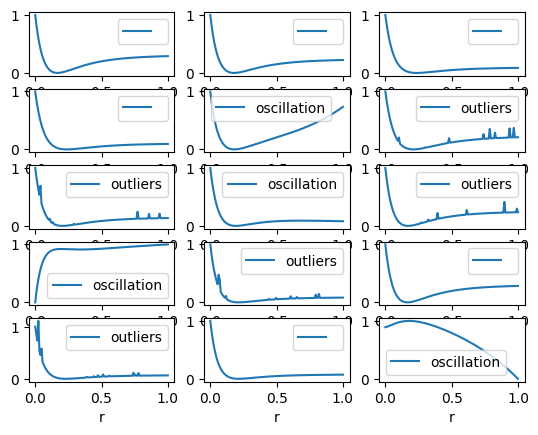

In [27]:
X_train, y_train, X_test, y_test, df_samples = generate_discriminator_training_set(
    n_samples,
    number_of_pts,
    properties_list,
    deformation_list,
    properties_format,
    test_split,
    gpu,
    generator_seed=[37, 43],
)


sample_visualization(df_samples)

### Discriminator model definition

In [19]:
model_parameters = {
    "in_features": X_train.shape[1] if properties_format == "array" else number_of_pts,
    "hidden_layers": [512, 128, 32],
    "out_features": 2,
}

model = AnnDiscriminator(model_parameters)
model = model.to("cuda" if gpu else "cpu")


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model

Training the model...
Training Losses:0.4608514904975891


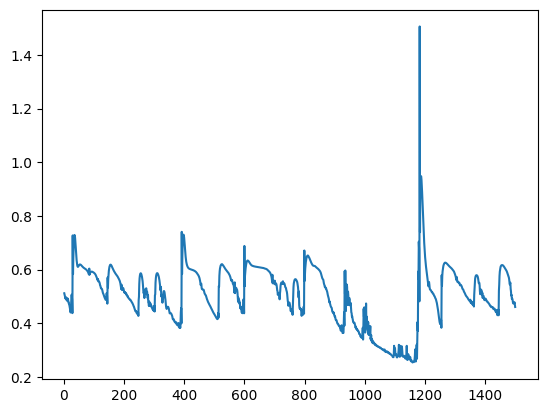

Evaluation:
Test Loss: 0.5045792460441589
Accuracy (%):  73.73333333333333


In [24]:
epochs = 1500

# Train the model
print("Training the model...")
losses = train_model(
    X_train, y_train, model, criterion, optimizer, epochs, verbose=False
)

print(f"Training Losses:{losses[-1]}")
plt.plot(range(2, epochs), losses[2:])
plt.show()


# Test the model
test_loss, accuracy = test_model(X_test, y_test, model, criterion)

### Get model failure information

Confusion Matrix:  Confusion Matrix
[[1821 1157]
 [   0 3022]]


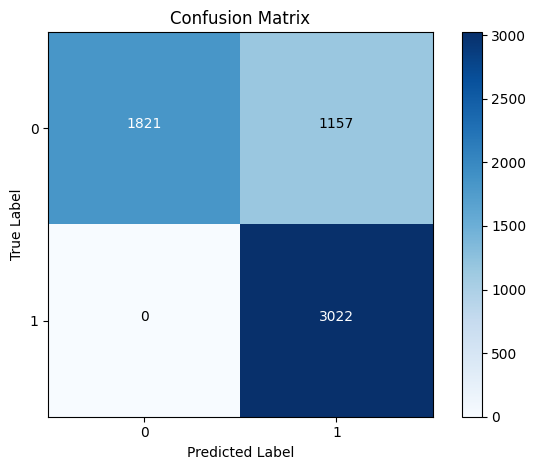



Failure Distribution by Deformation Type:
deformation_type
outliers       889
oscillation    268
Name: count, dtype: int64




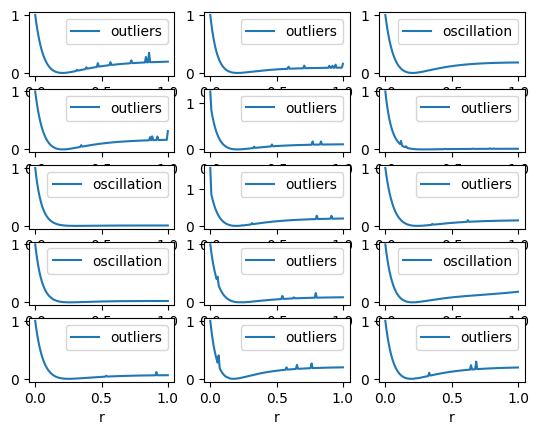

In [22]:
df_train = df_samples[df_samples.index < n_samples - int(n_samples * test_split)]
df_test = df_samples[df_samples.index >= n_samples - int(n_samples * test_split)]


get_model_failure_info(df_test, X_test, y_test, model)